In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d

In [2]:
def sir(y, t, beta, gamma, u_interp):
    S, I = y
    return np.array([-beta * S * I - u_interp(t) * S, beta * S * I - gamma * I])

In [3]:
def adjoint_sir(y, t, x_interp, beta, gamma, w1, w2, w3, u_interp):
    l_S, l_I = y
    S, I = x_interp(t)
    u = u_interp(t)
    dHdS = w2 * u + beta * I * (l_I - l_S) - u * l_S
    dHdI = w1 + beta * S * (l_I - l_S) - gamma * l_I
    return -np.array([dHdS, dHdI])

In [4]:
import sympy as sp

S, I, u = sp.symbols('S I u')
alpha, beta, gamma = sp.symbols('alpha beta gamma')

l_S, l_I = sp.symbols('lambda_S lambda_I')
l = sp.Matrix([l_S, l_I])

f = I + u*S + u**2
g = sp.Matrix([-beta*S*I -u*S, beta*S*I - gamma*I])

H = sp.Matrix([f + l.dot(g)])

In [5]:
H[0]

I + S*u + lambda_I*(I*S*beta - I*gamma) + lambda_S*(-I*S*beta - S*u) + u**2

In [6]:
sp.latex(H[0])

'I + S u + \\lambda_{I} \\left(I S \\beta - I \\gamma\\right) + \\lambda_{S} \\left(- I S \\beta - S u\\right) + u^{2}'

In [7]:
dHdx = H.jacobian([S, I])
dHdx

Matrix([[I*beta*lambda_I + lambda_S*(-I*beta - u) + u, -S*beta*lambda_S + lambda_I*(S*beta - gamma) + 1]])

In [8]:
dHdl = H.jacobian([l_S, l_I])
dHdl

Matrix([[-I*S*beta - S*u, I*S*beta - I*gamma]])

In [9]:
dHdu = H.jacobian([u])
dHdu

Matrix([[-S*lambda_S + S + 2*u]])

In [10]:
dHdx_fn = sp.lambdify([l_S, l_I, S, I, beta, gamma, u], dHdx)
dHdl_fn = sp.lambdify([l_S, l_I, S, I, beta, gamma, u], dHdl)
dHdu_fn = sp.lambdify([l_S, l_I, S, I, beta, gamma, u], dHdu)

In [11]:
def sir_by_sympy(y, t, beta_, gamma_, u_interp):
    S_, I_ = y
    u_ = u_interp(t)
    return dHdl_fn(0, 0, S_, I_, beta_, gamma_, u_)[0]

In [12]:
def adjoint_sir_by_sympy(y, t, x_interp, beta_, gamma_, w1, w2, w3, u_interp):
    l_S_, l_I_ = y
    S_, I_ = x_interp(t)
    u_ = u_interp(t)
    val = -dHdx_fn(l_S_, l_I_, S_, I_, beta_, gamma_, u_)[0]
    return val

In [13]:
t0 = 0
tf = 30
beta = 0.002
gamma = 0.5
S0 = 990
I0 = 10
w1, w2, w3 = 1, 1, 1

In [14]:
# Initial
y0 = np.array([S0, I0])
t = np.linspace(t0,tf, 301)
dt = t[1] - t[0]
u0 = np.ones_like(t)

In [15]:
# Initial
y0 = np.array([S0, I0])
t = np.linspace(t0,tf, 301)
dt = t[1] - t[0]
u0 = np.ones_like(t)

MaxIter = 500 + 1
alpha = 1E-1
old_cost = 1E8
for it in range(MaxIter):
    # State
    u_intp = lambda tc: np.interp(tc, t, u0)
    sol = odeint(sir_by_sympy, y0, t, args=(beta, gamma, u_intp))

    # Cost
    S, I = np.hsplit(sol, 2)
    S_mid = (S[1:] + S[:-1]) / 2.
    I_mid = (I[1:] + I[:-1]) / 2.
    u_mid = (u0[1:] + u0[:-1]) / 2.
    cost1 = dt * w1 * np.sum(I_mid.flatten())
    cost2 = dt * w2 * np.sum(S_mid.flatten() * u_mid)
    cost3 = dt * w3 * np.sum(u_mid.flatten() ** 2)
    cost = cost1 + cost2 + cost3

    # Adjoint
    u_intp = lambda tc: np.interp(tf - tc, t, u0)
    x_intp = lambda tc: np.array([np.interp(tf - tc, t, sol[:, 0]), np.interp(tf - tc, t, sol[:, 1])])
    y_T = np.array([0,0])
    l_sol = odeint(adjoint_sir_by_sympy, y_T, t, args=(x_intp, beta, gamma, w1, w2, w3, u_intp))
    l_sol = np.flipud(l_sol)

    # Simple Gradient
    # Hu = w2 * sol[:, 0] + 2 * w3 * u0 - l_sol[:,0] * sol[:, 0]
    Hu = dHdu_fn(l_sol[:,0], l_sol[:,1], sol[:, 0], sol[:, 1], beta, gamma, u0)[0][0]
    u1 = np.clip(u0 - alpha * Hu , 0, 1)
    if old_cost < cost:
        alpha = alpha / 1.1 # simple adaptive learning rate

    # Convergence
    if np.abs(old_cost - cost) / alpha  <= 1E-7:
        break

    old_cost = cost
    u0 = u1

In [16]:
dHdu

Matrix([[-S*lambda_S + S + 2*u]])

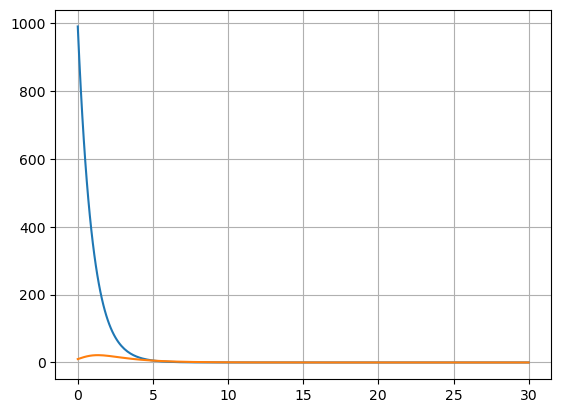

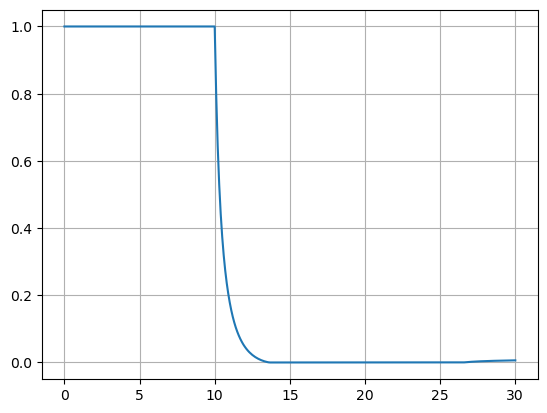

In [17]:
import matplotlib.pylab as plt
plt.plot(t, sol)
plt.grid()
plt.show()

plt.plot(t, u0)
plt.grid()
plt.show()